In [197]:
#import packages 
import networkx as nx
import json
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx
from collections import deque

In [195]:
#load cnty data 
file_path = '/Users/brookefeinberg/SamplingBalancedForests/cnty_ak.json'
with open(file_path, 'r') as file:
    data = json.load(file)
    cnty = json_graph.adjacency_graph(data)

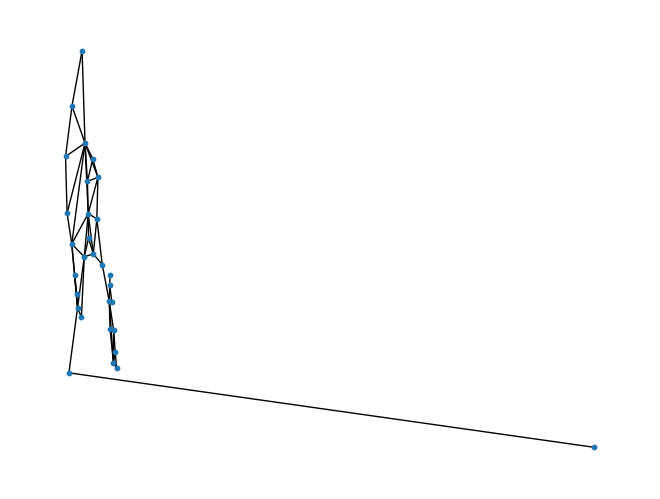

In [198]:
#plot 
import matplotlib.pyplot as plt
node_locations = { v : ( float(cnty.nodes()[v]["INTPTLON20"]), float(cnty.nodes()[v]["INTPTLAT20"])) for v in cnty.nodes() }
plt.figure()
nx.draw(cnty, node_size = 10, pos = node_locations)
plt.show()

In [199]:
#Wilson's Algorithm

class WilsonsAlgorithm:
    def __init__(self, graph):
        self.graph = graph  #store networkX graph 
        self.adj_list = {v: list(graph.neighbors(v)) for v in graph.nodes() if list(graph.neighbors(v))}  #for each graph node return the neighbors and store it as a dictionary where node is the key and each value corresponds to a list of its neighbors 
        self.InTree = {node: False for node in self.adj_list}  #initalizes dictionary to keep track of whether nodes have been included in the spanning tree -- FALSE as initial value menaing node has yet to be included in the tree 
        self.Next = {node: None for node in self.adj_list}  #initalizes dictionary to track path each node takes in a random walk 
    
    def random_edge(self, v): #randomly selects an edge for a given node v 
        return random.choice(self.adj_list[v]) #retrieves the list of neighbors for node v in the adjacency list and randomly picks one -- simulating step ina  random walk 

    def RandomTreeWithRoot(self, r): #generate random spanning tree with r as the root node 
        self.InTree = {node: False for node in self.adj_list} #initalize all nodes as not in the spanning tree 
        self.InTree[r] = True  #mark root node as in the tree 
        self.Next[r] = -1  #root node has no parent aka no incoming edges 

        for node in self.adj_list: #loops through each nodein the graph, attempting to find a path to the root using a random walk 
            path = []  
            while not self.InTree[node]: #loop continues as long as node is not already in the spanning tree 
                path.append(node)  #record each step of the random walk 
                self.Next[node] = self.random_edge(node) #choose a random neighbor & record it as the next step in the walk (connects node to its next random neighbor in the path)
                node = self.Next[node]  #update next node and the new node so the loop continues till we reach a node already in the spanning tree 
            for vertex in path:  #loop has broken bc we've reached a node already part of the spanning tree 
                self.InTree[vertex] = True  #adds each vertex to the spanning tree from the root outward 

    def sample(self, seed=None):
        if seed is not None: #can include seed later on for reproducible results 
            random.seed(seed)
        root = random.choice(list(self.adj_list.keys()))  #picks a random node to be a root 
        self.RandomTreeWithRoot(root) #builds ranodm spannign tree with the ranodm root chosen 

        spanning_tree = []  #extract edges of spannign tree for plotting 
        for node in self.adj_list: 
            if self.Next[node] != -1 and self.Next[node] is not None: #find nodes connected to another node in the tree 
                spanning_tree.append((node, self.Next[node])) #addes connection or edge as a tuple of two nodes to the spanning tree list 
        return spanning_tree, root #returns all the edges in the form of (node1, node2) and the root node 

    def draw_tree(self, spanning_tree, root, node_locations): #plot the spanning tree on the graph
        plt.figure(figsize=(8, 8))
        nx.draw(self.graph, pos=node_locations, node_size=10, edge_color='lightgray') #draw original graph 
        nx.draw_networkx_edges(self.graph, pos=node_locations, edgelist=spanning_tree, edge_color='red', width=2) #draw spanning tree 
        nx.draw_networkx_nodes(self.graph, pos=node_locations, nodelist=[root], node_color='yellow', node_size=50)  #draw root node 
        plt.show()

In [200]:
#BFS Graph Partitioner 
class GraphPartitioner:
    def __init__(self, graph, k):
        self.graph = graph
        self.k = k

    def create_weighted_partitions_and_draw_spanning_tree(self):
        while True:
            wilson = WilsonsAlgorithm(self.graph) #generate random spannign tree using wilson's algorithm 
            spanning_tree, root = wilson.sample() 

            tree_graph = nx.Graph() 
            tree_graph.add_edges_from(spanning_tree)  #take edges form spannign tree and add them to the new graph

            total_nodes = len(tree_graph) 
            ideal_size = total_nodes // self.k
            extra_nodes = total_nodes % self.k
            target_sizes = [ideal_size + 1 if i < extra_nodes else ideal_size for i in range(self.k)] #accomedate odd nodes 

            partitions = [[] for _ in range(self.k)] # initalize BFS queues 
            partition_sizes = [0] * self.k
            bfs_queues = [deque([root])] + [deque() for _ in range(self.k - 1)] 

            visited = set([root])
            partitions[0].append(root)
            partition_sizes[0] += 1

            for current_partition in range(self.k):
                while partition_sizes[current_partition] < target_sizes[current_partition] and bfs_queues[current_partition]:
                    node = bfs_queues[current_partition].popleft()
                    for neighbor in tree_graph.neighbors(node):
                        if neighbor not in visited:
                            partitions[current_partition].append(neighbor)
                            partition_sizes[current_partition] += 1
                            visited.add(neighbor)
                            bfs_queues[current_partition].append(neighbor)
                            if partition_sizes[current_partition] >= target_sizes[current_partition]:
                                break
                            
                # check if partition has reached the right size--else continue the loop for a new tree            
                if partition_sizes[current_partition] < target_sizes[current_partition]:
                    #print("Attempt failed, generating a new spanning tree.")
                    return False          #initalizae for statistical inference 
                    #break  

                # initalize next partition with an unvisited node 
                unvisited_nodes = [n for n in tree_graph.nodes if n not in visited]
                if unvisited_nodes and current_partition + 1 < self.k:
                    seed_node = unvisited_nodes[0]
                    partitions[current_partition + 1].append(seed_node)
                    partition_sizes[current_partition + 1] += 1
                    visited.add(seed_node)
                    bfs_queues[current_partition + 1].append(seed_node)

            # check if all partitions are the right size
            if all(partition_sizes[i] == target_sizes[i] for i in range(self.k)):
                #print("Balanced partitions found.")
                return True
                #break
              
        # Step 3: Plotting 
        node_locations = {v: (float(cnty.nodes()[v]["INTPTLON20"]) - 360 if float(cnty.nodes()[v]["INTPTLON20"]) > 0 else float(cnty.nodes()[v]["INTPTLON20"]),
        float(cnty.nodes()[v]["INTPTLAT20"]))for v in cnty.nodes()}
        pos = node_locations
        plt.figure(figsize=(10, 10))
        base_colors = ['blue', 'green']
        spanning_tree_pos = {node: pos[node] for node in tree_graph.nodes}
        for i, partition in enumerate(partitions):
            nx.draw_networkx_nodes(tree_graph, spanning_tree_pos, nodelist=partition, node_size=50,
                                   node_color=base_colors[i % len(base_colors)], label=f'Partition {i+1}')
        nx.draw_networkx_edges(tree_graph, spanning_tree_pos, edge_color='gray', width=2)
        plt.legend()
        plt.title("Spanning Tree with Weighted, Connected, Balanced Partitions")
        plt.show()
        return True


G = cnty  
k = 2 
partitioner = GraphPartitioner(G, k)
partitioner.create_weighted_partitions_and_draw_spanning_tree()

False

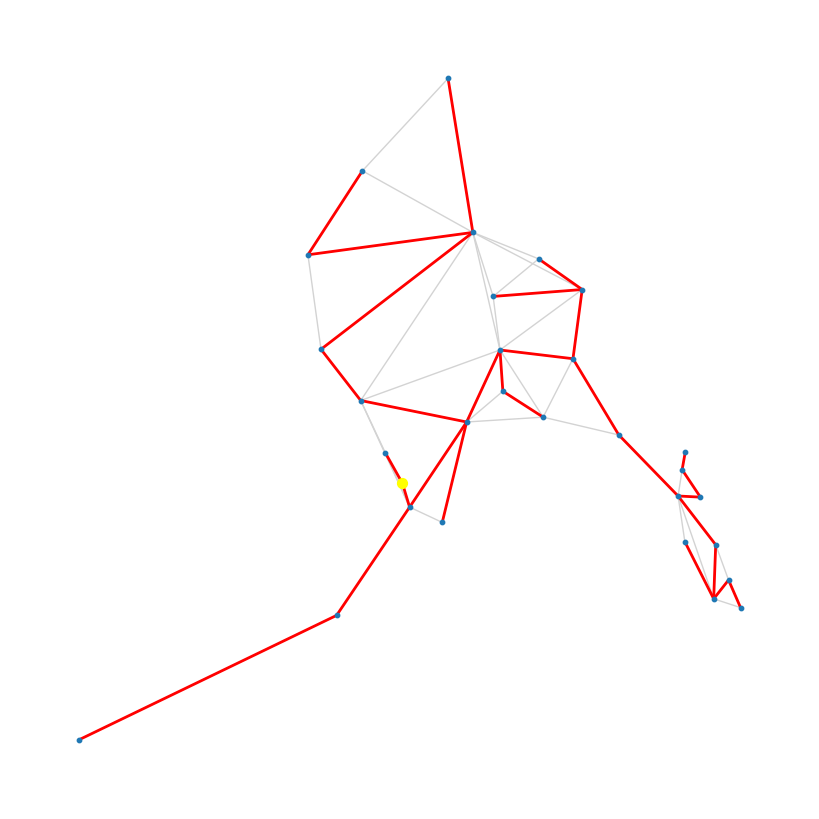

In [201]:
#plot of cnty's spannig tree 
node_locations = {v: (float(cnty.nodes()[v]["INTPTLON20"]) - 360 if float(cnty.nodes()[v]["INTPTLON20"]) > 0 else float(cnty.nodes()[v]["INTPTLON20"]),
        float(cnty.nodes()[v]["INTPTLAT20"]))for v in cnty.nodes()}
wilson = WilsonsAlgorithm(cnty)
spanning_tree, root = wilson.sample()
wilson.draw_tree(spanning_tree, root, node_locations)

In [205]:
def run_partition_simulations(graph, p, k):
    successful_splits = 0
    trials = 0

    while successful_splits < k:
        trials += 1
        partitioner = GraphPartitioner(graph, p)
        
        if partitioner.create_weighted_partitions_and_draw_spanning_tree():
            successful_splits += 1

    success_rate= (k/trials)*100

    print(f"It took {trials} trials to achieve {k} successful splits for {p} partitions.")
    print(f"average success rate is {success_rate}")


run_partition_simulations(cnty, p=4, k=178)  

KeyboardInterrupt: 

In [183]:
cnty_data= {
    "oregon": {"counties": 36, "avg_success_rate": 0.8218672084218303},
    "alabama": {"counties": 67, "avg_success_rate": 0.19185169217503772},
    "arkansas": {"counties": 75, "avg_success_rate": 0.0735987298016969},
    "colorado": {"counties": 64, "avg_success_rate": 0.22064930396301025},
    "florida": {"counties": 67, "avg_success_rate": 0.36863687197117173},
    "georgia": {"counties": 159, "avg_success_rate": 0.02972075844704028},
    "hawaii": {"counties": 5, "avg_success_rate": 100.0},
    "iowa": {"counties": 99, "avg_success_rate": 0.10163994335571697},
    "idaho": {"counties": 44, "avg_success_rate": 0.3692639614969712},
    "illinois": {"counties": 102, "avg_success_rate": 0.100015732811903},
    "indiana": {"counties": 92, "avg_success_rate": 0.09383632414651119},
    "kentucky": {"counties": 120, "avg_success_rate": 0.057083482990404846},
    "louisiana": {"counties": 64, "avg_success_rate": 0.2811428932446733},
    "maryland": {"counties": 24, "avg_success_rate": 1.2403316842031913},
    "maine": {"counties": 16, "avg_success_rate": 6.428313470566992},
    "michigan": {"counties": 83, "avg_success_rate": 0.1483531137484998},
    "minnesota": {"counties": 87, "avg_success_rate": 0.10272154382401145},
    "missouri": {"counties": 115, "avg_success_rate": 0.05012954827081221},
    "mississippi": {"counties": 82, "avg_success_rate": 0.11018328804263723},
    "montana": {"counties": 56, "avg_success_rate": 0.2651453085665768},
    "northcarolina": {"counties": 100, "avg_success_rate": 0.101988196871598},
    "northdakota": {"counties": 53, "avg_success_rate": 0.3136729694961848},
    "nebraska": {"counties": 93, "avg_success_rate": 0.10384337152591416},
    "newhampshire": {"counties": 10, "avg_success_rate": 14.004720692368213},
    "newjersey": {"counties": 21, "avg_success_rate": 2.4244075183873606},
    "newmexico": {"counties": 33, "avg_success_rate": 0.9306216343388928},
    "newyork": {"counties": 62, "avg_success_rate": 0.5725129458685794},
    "ohio": {"counties": 88, "avg_success_rate": 0.08080551293342171},
    "rhodeisland": {"counties": 5, "avg_success_rate": 69.53125},
    "southcarolina": {"counties": 46, "avg_success_rate": 0.4745907321495228},
    "southdakota": {"counties": 66, "avg_success_rate": 0.2451452967910756},
    "tennessee": {"counties": 95, "avg_success_rate": 0.11686614886646401},
    "texas": {"counties": 254, "avg_success_rate": 0.009447601901409497},
    "utah": {"counties": 29, "avg_success_rate": 1.8627040602762663},
    "virginia": {"counties": 133, "avg_success_rate": 0.046805399975808445},
    "vermont": {"counties": 14, "avg_success_rate": 11.858760826115923},
    "washington": {"counties": 39, "avg_success_rate": 0.8418862034715981},
    "wisconsin": {"counties": 72, "avg_success_rate": 0.21315578334750382},
    "westvirginia": {"counties": 55, "avg_success_rate": 0.23520395354061233},
    "wyoming": {"counties": 23, "avg_success_rate": 1.5686965717810875},
    "alaska": {"counties": 30, "avg_success_rate": 1.5450047738911554}
}

In [210]:
#import packages 
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

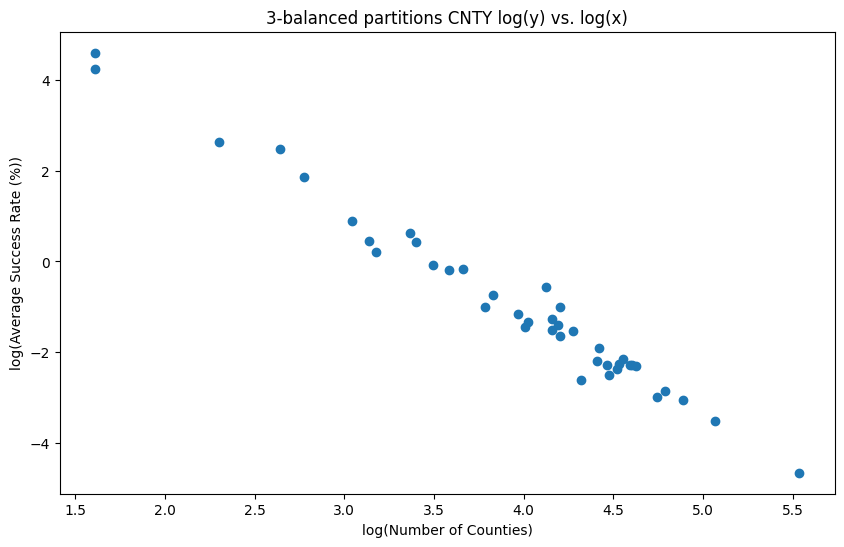

In [185]:
#creating new log variables 
counties = [state_data["counties"] for state_data in cnty_data.values()]
counties = np.array(counties)
log_counties= np.log(counties)
avg_success_rates = [state_data["avg_success_rate"] for state_data in cnty_data.values()]
avg_success_rates = np.array(avg_success_rates)
log_avg_success_rates= np.log(avg_success_rates)
states = list(cnty_data.keys())

plt.figure(figsize=(10, 6))
plt.scatter(log_counties, log_avg_success_rates)

plt.xlabel("log(Number of Counties)")
plt.ylabel("log(Average Success Rate (%))")
plt.title("3-balanced partitions CNTY log(y) vs. log(x)")

plt.show()


In [186]:
print(len(counties))

41


Linear Regression:
Original formula: ln(y) = -2.2782 * ln(x) + 8.0138
MSE = 0.0840, R^2 = 0.9782



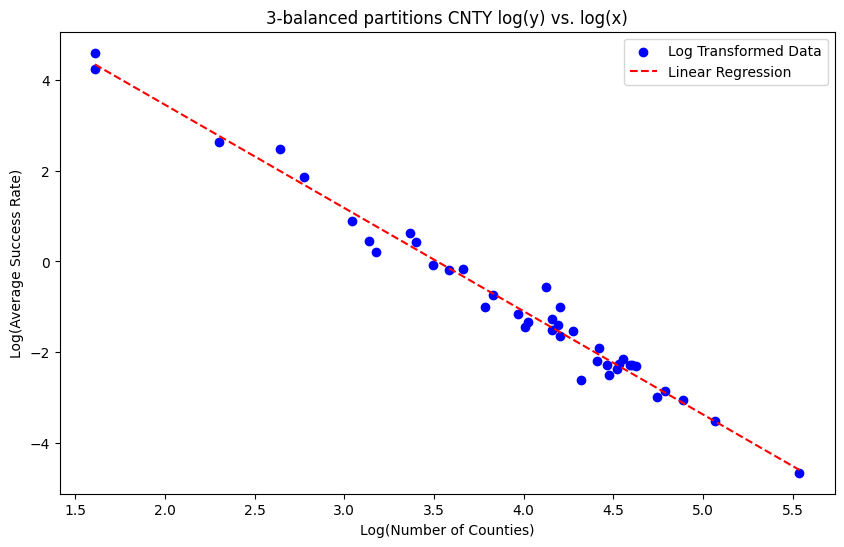

In [187]:
#ln(y) ~ ln(x)
def linear_regression(log_x, a, b): 
    return (a*log_x) +b 

params_linear, _ = curve_fit(linear_regression, log_counties, log_avg_success_rates, maxfev=10000)
a_linear, b_linear = params_linear

pred_linear = linear_regression(log_counties, a_linear, b_linear)

mse_linear = mean_squared_error(log_avg_success_rates, pred_linear)
r2_linear = r2_score(log_avg_success_rates, pred_linear)

print(f"Linear Regression:")
print(f"Original formula: ln(y) = {a_linear:.4f} * ln(x) + {b_linear:.4f}")
print(f"MSE = {mse_linear:.4f}, R^2 = {r2_linear:.4f}\n")

x_vals_log = np.linspace(min(log_counties), max(log_counties), 500)
y_vals_linear = linear_regression(x_vals_log, a_linear, b_linear)
plt.figure(figsize=(10, 6))
plt.scatter(log_counties, log_avg_success_rates, color='blue', label="Log Transformed Data")
plt.plot(x_vals_log, y_vals_linear, "r--", label="Linear Regression")

plt.xlabel("Log(Number of Counties)")
plt.ylabel("Log(Average Success Rate)")
plt.title("3-balanced partitions CNTY log(y) vs. log(x)")
plt.legend()
plt.show()

Linear Regression:
Original formula: ln(y) = -0.0357 * x + 1.4707
MSE = 1.0846, R^2 = 0.7187



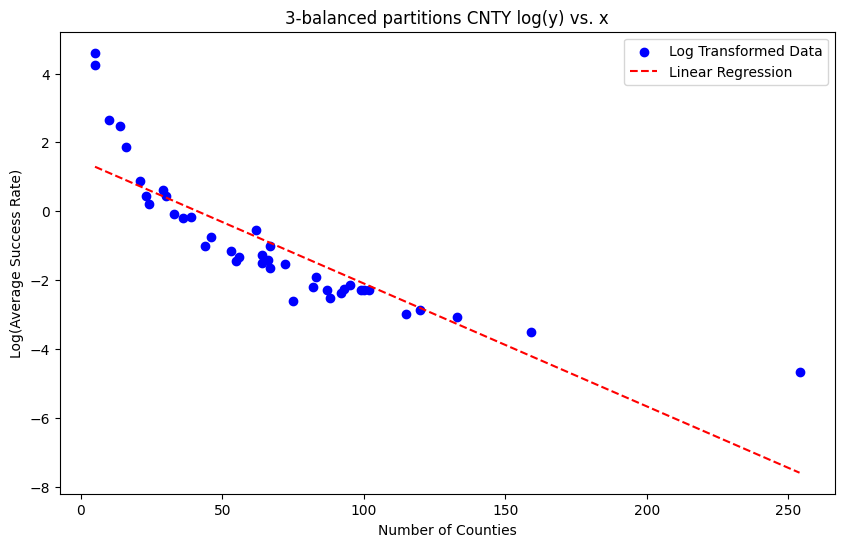

In [188]:
#ln(y)~ x 
def linear_regression(plain_x, a, b): 
    return (a * plain_x) +b 

params_linear, _ = curve_fit(linear_regression, counties, log_avg_success_rates, maxfev=10000)
a_linear, b_linear = params_linear

pred_linear = linear_regression(counties, a_linear, b_linear)

mse_linear = mean_squared_error(log_avg_success_rates, pred_linear)
r2_linear = r2_score(log_avg_success_rates, pred_linear)

print(f"Linear Regression:")
print(f"Original formula: ln(y) = {a_linear:.4f} * x + {b_linear:.4f}")
print(f"MSE = {mse_linear:.4f}, R^2 = {r2_linear:.4f}\n")

x_vals_log = np.linspace(min(counties), max(counties), 500)
y_vals_linear = linear_regression(x_vals_log, a_linear, b_linear)
plt.figure(figsize=(10, 6))
plt.scatter(counties, log_avg_success_rates, color='blue', label="Log Transformed Data")
plt.plot(x_vals_log, y_vals_linear, "r--", label="Linear Regression")

plt.xlabel("Number of Counties")
plt.ylabel("Log(Average Success Rate)")
plt.title("3-balanced partitions CNTY log(y) vs. x")
plt.legend()
plt.show()

Polynomial formula: y = 3022.38036 * x^-2.2782
MSE = 14.7228, R^2 = 0.9571

Exponential formula: y = 4.352 * e^-0.0357x
MSE = 337.7984, R^2 = 0.0158



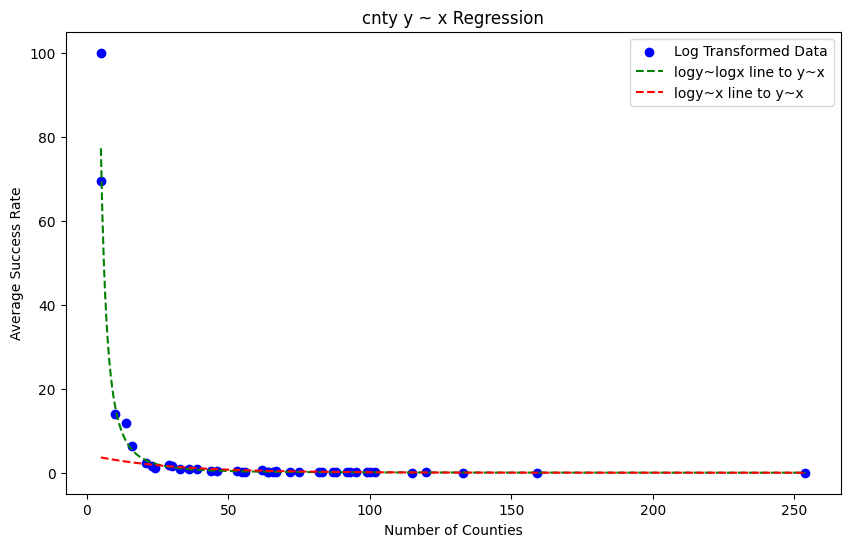

In [ ]:
#transforming ln(y) ~ ln(x) back in terms of y ~ x
def poly_fit(x): 
    return 3022.38036 * (x ** -2.2782)

#transforming ln(y) ~ x back in terms of y ~ x
def expo_fit(x): 
    return 4.352 * np.exp(-0.0357 * x)

pred_poly = poly_fit(counties)
pred_expo = expo_fit(counties)

mse_poly = mean_squared_error(avg_success_rates, pred_poly)
r2_poly = r2_score(avg_success_rates, pred_poly)

mse_expo = mean_squared_error(avg_success_rates, pred_expo)
r2_expo = r2_score(avg_success_rates, pred_expo)

n = len(avg_success_rates)  
mse_manual_poly = np.sum((avg_success_rates - pred_poly) ** 2) / n

n = len(avg_success_rates)  
mse_manual_expo = np.sum((avg_success_rates - pred_expo) ** 2) / n


print(f"Polynomial formula: y = 3022.38036 * x^-2.2782")
print(f"MSE = {mse_poly:.4f}, R^2 = {r2_poly:.4f}\n")
#print(f"Manually Computed MSE for poly: {mse_manual_poly:.4f}")

print(f"Exponential formula: y = 4.352 * e^-0.0357x")
print(f"MSE = {mse_expo:.4f}, R^2 = {r2_expo:.4f}\n")
#print(f"Manually Computed MSE for expo: {mse_manual_expo:.4f}")

x_vals = np.linspace(min(counties), max(counties), 500)
y_vals_poly = np.array(poly_fit(x_vals))
y_vals_expo = np.array(expo_fit(x_vals))

plt.figure(figsize=(10, 6))
plt.scatter(counties, avg_success_rates, color='blue', label="Log Transformed Data")
plt.plot(x_vals, y_vals_poly, "g--", label="logy~logx line to y~x")
plt.plot(x_vals, y_vals_expo, "r--", label="logy~x line to y~x")
plt.xlabel("Number of Counties")
plt.ylabel("Average Success Rate")
plt.title("cnty y ~ x Regression")
plt.legend()
plt.show()

In [206]:
import os
import json
import networkx.readwrite.json_graph as json_graph

# Set the base directory where all the files are stored
base_dir = '/Users/brookefeinberg/SamplingBalancedForests/'

# List of all 50 US state abbreviations
state_abbrs = [
    "ak", "al", "ar", "az", "ca", "co", "ct", "de", "fl", "ga",
    "hi", "ia", "id", "il", "in", "ks", "ky", "la", "ma", "md",
    "me", "mi", "mn", "mo", "ms", "mt", "nc", "nd", "ne", "nh",
    "nj", "nm", "nv", "ny", "oh", "ok", "or", "pa", "ri", "sc",
    "sd", "tn", "tx", "ut", "va", "vt", "wa", "wi", "wv", "wy"
]

# Dictionary to store graph data for each state
state_graphs = {}

# Iterate through each state abbreviation and load the corresponding JSON
for abbr in state_abbrs:
    file_path = os.path.join(base_dir, f'cnty_{abbr}.json')
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            graph = json_graph.adjacency_graph(data)
            state_graphs[abbr] = graph
            print(f"Loaded graph for {abbr.upper()} with {len(graph)} nodes.")
    except FileNotFoundError:
        print(f"File not found for {abbr.upper()}: {file_path}")
    except Exception as e:
        print(f"Error loading {abbr.upper()}: {e}")

Loaded graph for AK with 30 nodes.
Loaded graph for AL with 67 nodes.
Loaded graph for AR with 75 nodes.
Loaded graph for AZ with 15 nodes.
Loaded graph for CA with 58 nodes.
Loaded graph for CO with 64 nodes.
Loaded graph for CT with 8 nodes.
Loaded graph for DE with 3 nodes.
Loaded graph for FL with 67 nodes.
Loaded graph for GA with 159 nodes.
Loaded graph for HI with 5 nodes.
Loaded graph for IA with 99 nodes.
Loaded graph for ID with 44 nodes.
Loaded graph for IL with 102 nodes.
Loaded graph for IN with 92 nodes.
Loaded graph for KS with 105 nodes.
Loaded graph for KY with 120 nodes.
Loaded graph for LA with 64 nodes.
Loaded graph for MA with 14 nodes.
Loaded graph for MD with 24 nodes.
Loaded graph for ME with 16 nodes.
Loaded graph for MI with 83 nodes.
Loaded graph for MN with 87 nodes.
Loaded graph for MO with 115 nodes.
Loaded graph for MS with 82 nodes.
Loaded graph for MT with 56 nodes.
Loaded graph for NC with 100 nodes.
Loaded graph for ND with 53 nodes.
Loaded graph for 

In [ ]:
def run_partition_simulations(graph, p, k):
    successful_splits = 0
    trials = 0

    while successful_splits < k:
        trials += 1
        partitioner = GraphPartitioner(graph, p)
        
        if partitioner.create_weighted_partitions_and_draw_spanning_tree():
            successful_splits += 1

    success_rate = (k / trials) * 100
    return trials, success_rate


# Run partition simulations for all 50 states
p = 4  # Number of partitions
k = 178  # Number of successful splits to target

results = {}  # Store results for each state

for abbr, graph in state_graphs.items():
    print(f"\nRunning simulations for {abbr.upper()}")
    try:
        trials, success_rate = run_partition_simulations(graph, p, k)
        results[abbr] = {
            "trials": trials,
            "success_rate": success_rate
        }
        print(f"{abbr.upper()}: Took {trials} trials → Success Rate: {success_rate:.2f}%")
    except Exception as e:
        print(f"Error running partition simulations for {abbr.upper()}: {e}")

In [215]:
cnty_data = {
    "oregon": {"counties": 36, "avg_success_rate": 0.1896138482023968},
    "alabama": {"counties": 67, "avg_success_rate": 0.02448445099808526},
    "arkansas": {"counties": 75, "avg_success_rate": 0.02264314154507639},
    "colorado": {"counties": 64, "avg_success_rate": 0.028159655756118396},
    "florida": {"counties": 67, "avg_success_rate": 0.0504330727624574},
    "georgia": {"counties": 159, "avg_success_rate": 0.0014323205217895382},
    "hawaii": {"counties": 5, "avg_success_rate": 100.0},
    "iowa": {"counties": 99, "avg_success_rate": 0.006920579353579009},
    "idaho": {"counties": 44, "avg_success_rate": 0.08078350927194997},
    "illinois": {"counties": 102, "avg_success_rate": 0.00630592746553793},
    "indiana": {"counties": 92, "avg_success_rate": 0.0068651756636465035},
    "kentucky": {"counties": 120, "avg_success_rate": 0.004775724722934184},
    "louisiana": {"counties": 64, "avg_success_rate": 0.03226139706348789},
    "maine": {"counties": 16, "avg_success_rate": 2.3774542540403365},
    "michigan": {"counties": 83, "avg_success_rate": 0.0090831248807202},
    "minnesota": {"counties": 87, "avg_success_rate": 0.009127802568707226},
    "missouri": {"counties": 115, "avg_success_rate": 0.00424551275538071},
    "mississippi": {"counties": 82, "avg_success_rate": 0.00854795257326988},
    "montana": {"counties": 56, "avg_success_rate": 0.04230510537060936},
    "northcarolina": {"counties": 100, "avg_success_rate": 0.005205074069958535},
    "northdakota": {"counties": 53, "avg_success_rate": 0.05584944495692063},
    "nebraska": {"counties": 93, "avg_success_rate": 0.009477915923431219},
    "newhampshire": {"counties": 10, "avg_success_rate": 12.326869806094184},
    "newjersey": {"counties": 21, "avg_success_rate": 1.3956405833464012},
    "newmexico": {"counties": 33, "avg_success_rate": 0.24355536095451807},
    "newyork": {"counties": 62, "avg_success_rate": 0.06404213828784422},
    "ohio": {"counties": 88, "avg_success_rate": 0.006910946628855765},
    "rhodeisland": {"counties": 5, "avg_success_rate": 100.0},
    "southcarolina": {"counties": 46, "avg_success_rate": 0.06540006099106811},
    "southdakota": {"counties": 66, "avg_success_rate": 0.031120839773132573},
    "tennessee": {"counties": 95, "avg_success_rate": 0.011668297824780188},
    "utah": {"counties": 29, "avg_success_rate": 0.59},
    "vermont": {"counties": 14, "avg_success_rate": 4.97},
    "washington": {"counties": 39, "avg_success_rate": 0.17},
    "wisconsin": {"counties": 72, "avg_success_rate": 0.02},
    "westvirginia": {"counties": 55, "avg_success_rate": 0.03},
    "wyoming": {"counties": 23, "avg_success_rate": 0.74},
    "alaska": {"counties": 30, "avg_success_rate": 1.5450047738911554}
}

In [218]:
len(cnty_data)

38

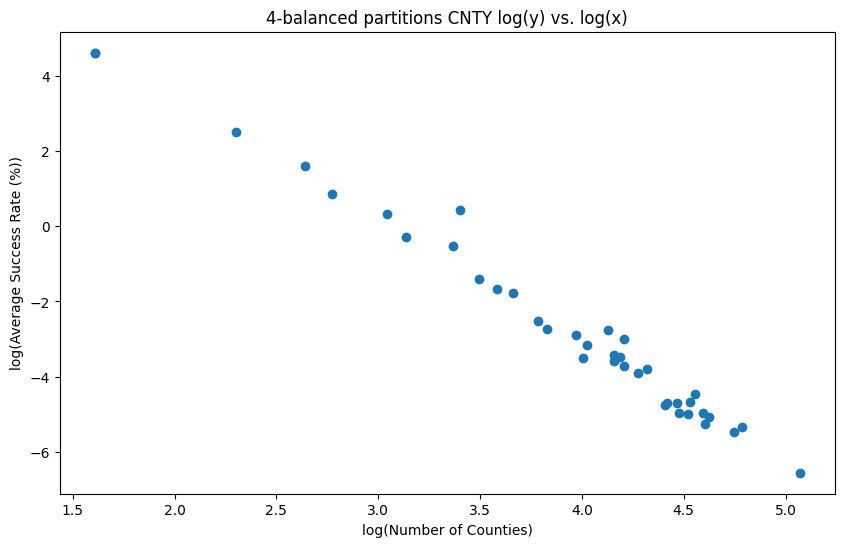

In [220]:
#creating new log variables 
counties = [state_data["counties"] for state_data in cnty_data.values()]
counties = np.array(counties)
log_counties= np.log(counties)
avg_success_rates = [state_data["avg_success_rate"] for state_data in cnty_data.values()]
avg_success_rates = np.array(avg_success_rates)
log_avg_success_rates= np.log(avg_success_rates)
states = list(cnty_data.keys())

plt.figure(figsize=(10, 6))
plt.scatter(log_counties, log_avg_success_rates)

plt.xlabel("log(Number of Counties)")
plt.ylabel("log(Average Success Rate (%))")
plt.title("4-balanced partitions CNTY log(y) vs. log(x)")

plt.show()

Linear Regression:
Original formula: ln(y) = -3.2797 * ln(x) + 10.1405
MSE = 0.1254, R^2 = 0.9830



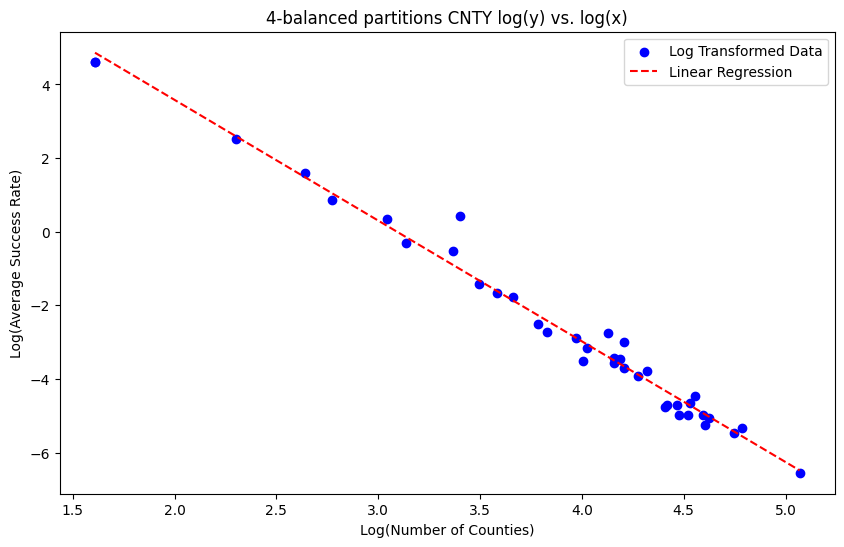

In [221]:
#ln(y) ~ ln(x)
def linear_regression(log_x, a, b): 
    return (a*log_x) +b 

params_linear, _ = curve_fit(linear_regression, log_counties, log_avg_success_rates, maxfev=10000)
a_linear, b_linear = params_linear

pred_linear = linear_regression(log_counties, a_linear, b_linear)

mse_linear = mean_squared_error(log_avg_success_rates, pred_linear)
r2_linear = r2_score(log_avg_success_rates, pred_linear)

print(f"Linear Regression:")
print(f"Original formula: ln(y) = {a_linear:.4f} * ln(x) + {b_linear:.4f}")
print(f"MSE = {mse_linear:.4f}, R^2 = {r2_linear:.4f}\n")

x_vals_log = np.linspace(min(log_counties), max(log_counties), 500)
y_vals_linear = linear_regression(x_vals_log, a_linear, b_linear)
plt.figure(figsize=(10, 6))
plt.scatter(log_counties, log_avg_success_rates, color='blue', label="Log Transformed Data")
plt.plot(x_vals_log, y_vals_linear, "r--", label="Linear Regression")

plt.xlabel("Log(Number of Counties)")
plt.ylabel("Log(Average Success Rate)")
plt.title("4-balanced partitions CNTY log(y) vs. log(x)")
plt.legend()
plt.show()

Linear Regression:
Original formula: ln(y) = -0.0702 * x + 1.7682
MSE = 1.2694, R^2 = 0.8282



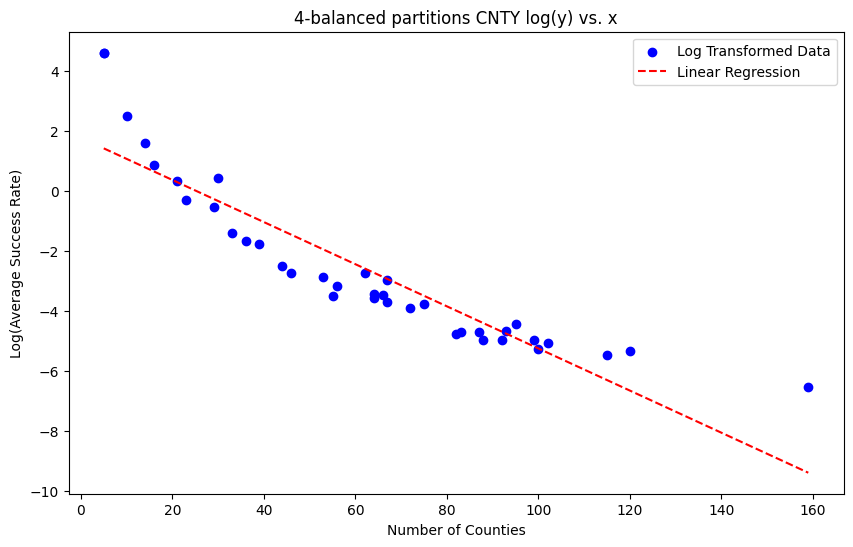

In [223]:
#ln(y)~ x 
def linear_regression(plain_x, a, b): 
    return (a * plain_x) +b 

params_linear, _ = curve_fit(linear_regression, counties, log_avg_success_rates, maxfev=10000)
a_linear, b_linear = params_linear

pred_linear = linear_regression(counties, a_linear, b_linear)

mse_linear = mean_squared_error(log_avg_success_rates, pred_linear)
r2_linear = r2_score(log_avg_success_rates, pred_linear)

print(f"Linear Regression:")
print(f"Original formula: ln(y) = {a_linear:.4f} * x + {b_linear:.4f}")
print(f"MSE = {mse_linear:.4f}, R^2 = {r2_linear:.4f}\n")

x_vals_log = np.linspace(min(counties), max(counties), 500)
y_vals_linear = linear_regression(x_vals_log, a_linear, b_linear)
plt.figure(figsize=(10, 6))
plt.scatter(counties, log_avg_success_rates, color='blue', label="Log Transformed Data")
plt.plot(x_vals_log, y_vals_linear, "r--", label="Linear Regression")

plt.xlabel("Number of Counties")
plt.ylabel("Log(Average Success Rate)")
plt.title("4-balanced partitions CNTY log(y) vs. x")
plt.legend()
plt.show()

Polynomial formula: y = 25349.1378 * x^-3.2797
MSE = 45.2194, R^2 = 0.9089

Exponential formula: y = 5.8602 * e^-0.0702x
MSE = 486.3629, R^2 = 0.0197



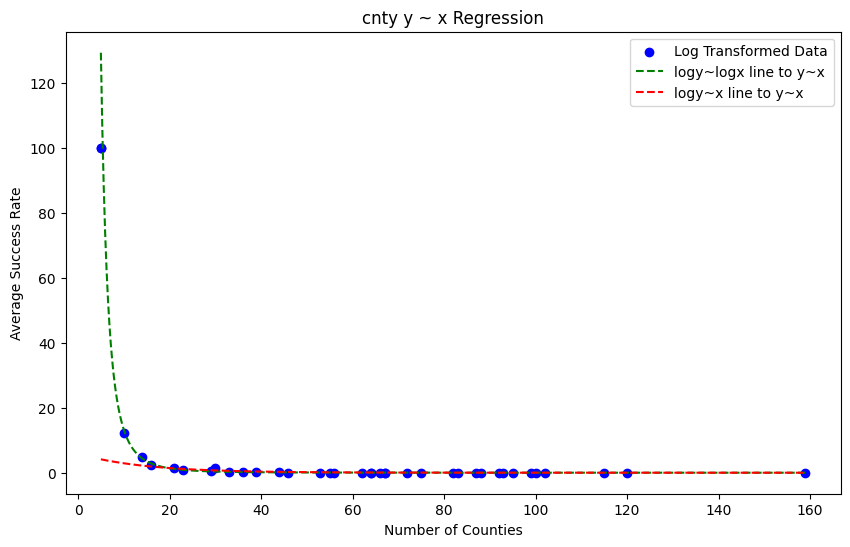

In [225]:
#transforming ln(y) ~ ln(x) back in terms of y ~ x
def poly_fit(x): 
    return 25349.1378 * (x ** -3.2797)

#transforming ln(y) ~ x back in terms of y ~ x
def expo_fit(x): 
    return 5.8602 * np.exp(-0.0702 * x)

pred_poly = poly_fit(counties)
pred_expo = expo_fit(counties)

mse_poly = mean_squared_error(avg_success_rates, pred_poly)
r2_poly = r2_score(avg_success_rates, pred_poly)

mse_expo = mean_squared_error(avg_success_rates, pred_expo)
r2_expo = r2_score(avg_success_rates, pred_expo)

n = len(avg_success_rates)  
mse_manual_poly = np.sum((avg_success_rates - pred_poly) ** 2) / n

n = len(avg_success_rates)  
mse_manual_expo = np.sum((avg_success_rates - pred_expo) ** 2) / n


print(f"Polynomial formula: y = 25349.1378 * x^-3.2797")
print(f"MSE = {mse_poly:.4f}, R^2 = {r2_poly:.4f}\n")
#print(f"Manually Computed MSE for poly: {mse_manual_poly:.4f}")

print(f"Exponential formula: y = 5.8602 * e^-0.0702x")
print(f"MSE = {mse_expo:.4f}, R^2 = {r2_expo:.4f}\n")
#print(f"Manually Computed MSE for expo: {mse_manual_expo:.4f}")

x_vals = np.linspace(min(counties), max(counties), 500)
y_vals_poly = np.array(poly_fit(x_vals))
y_vals_expo = np.array(expo_fit(x_vals))

plt.figure(figsize=(10, 6))
plt.scatter(counties, avg_success_rates, color='blue', label="Log Transformed Data")
plt.plot(x_vals, y_vals_poly, "g--", label="logy~logx line to y~x")
plt.plot(x_vals, y_vals_expo, "r--", label="logy~x line to y~x")
plt.xlabel("Number of Counties")
plt.ylabel("Average Success Rate")
plt.title("cnty y ~ x Regression")
plt.legend()
plt.show()